In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold, train_test_split
import numpy as np
from tqdm import tqdm  # 导入tqdm库

# Image preprocessing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Dataset path
data_dir = 'dataset'
batch_size = 32
num_epochs = 5
k_folds = 3
num_classes = 3


dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
dataset_size = len(dataset)
indices = list(range(dataset_size))

# Divide the training set and test set
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42, stratify=dataset.targets)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, dataloader, dataset_size):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    
    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, dataset_size):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    
    return epoch_loss, epoch_acc

# Cross Validation
train_indices = np.array(train_indices)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    train_sampler = SubsetRandomSampler(train_indices[train_idx])
    val_sampler = SubsetRandomSampler(train_indices[val_idx])
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    model = models.swin_v2_s(weights=models.Swin_V2_S_Weights.IMAGENET1K_V1)
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, len(train_idx))
        val_loss, val_acc = validate_model(model, criterion, val_loader, len(val_idx))
        
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
    
    print(f'Best Val Acc: {best_acc:.4f}')
    
    # Save the best model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'model_fold_{fold + 1}.pth')

# Evaluate on the test set
model.load_state_dict(torch.load('model_fold_1.pth'))
test_loss, test_acc = validate_model(model, criterion, test_loader, len(test_indices))
print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')


Fold 1/3
Epoch 1/5
----------


Train Loss: 0.6605 Acc: 0.7354
Val Loss: 0.1287 Acc: 0.9833
Epoch 2/5
----------


Train Loss: 0.0813 Acc: 0.9896
Val Loss: 0.0406 Acc: 0.9917
Epoch 3/5
----------


Train Loss: 0.0292 Acc: 0.9896
Val Loss: 0.0325 Acc: 0.9917
Epoch 4/5
----------


Train Loss: 0.0163 Acc: 0.9979
Val Loss: 0.0256 Acc: 0.9917
Epoch 5/5
----------


Train Loss: 0.0079 Acc: 1.0000
Val Loss: 0.0325 Acc: 0.9917
Best Val Acc: 0.9917
Fold 2/3
Epoch 1/5
----------


Train Loss: 0.6952 Acc: 0.7208
Val Loss: 0.1493 Acc: 0.9917
Epoch 2/5
----------


Train Loss: 0.0817 Acc: 0.9875
Val Loss: 0.0256 Acc: 0.9875
Epoch 3/5
----------


Train Loss: 0.0281 Acc: 0.9938
Val Loss: 0.0181 Acc: 0.9917
Epoch 4/5
----------


Train Loss: 0.0153 Acc: 0.9979
Val Loss: 0.0147 Acc: 0.9917
Epoch 5/5
----------


Train Loss: 0.0088 Acc: 0.9979
Val Loss: 0.0138 Acc: 0.9958
Best Val Acc: 0.9958
Fold 3/3
Epoch 1/5
----------


Train Loss: 0.5737 Acc: 0.8104
Val Loss: 0.1010 Acc: 1.0000
Epoch 2/5
----------


Train Loss: 0.0795 Acc: 0.9854
Val Loss: 0.0088 Acc: 0.9958
Epoch 3/5
----------


Train Loss: 0.0209 Acc: 0.9938
Val Loss: 0.0046 Acc: 0.9958
Epoch 4/5
----------


Train Loss: 0.0141 Acc: 0.9958
Val Loss: 0.0033 Acc: 1.0000
Epoch 5/5
----------


Train Loss: 0.0062 Acc: 1.0000
Val Loss: 0.0027 Acc: 1.0000
Best Val Acc: 1.0000


C:\Users\wjc20\AppData\Local\Temp\ipykernel_24080\1654419220.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_fold_1.pth'))
    

Test Loss: 0.0008 Acc: 1.0000


In [25]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

class ConvertToRGB:
    def __call__(self, img):
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        return img


data_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# load the model
model_path = 'model_fold_2.pth'  
num_classes = 3
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


image_path = 'Flower28.jpg'  
image = Image.open(image_path)
image = data_transforms(image)
image = image.unsqueeze(0)  


image = image.to(device)

# classification
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    predicted_class = preds.item()
    predicted_prob = probabilities[0][preds].item()


class_names = ['flower', 'pod', 'seed']  # 请根据实际情况修改
predicted_label = class_names[predicted_class]

print(f'The image is classified as: {predicted_label} with a probability of {predicted_prob:.4f}')



C:\Users\wjc20\AppData\Local\Temp\ipykernel_22680\3164979250.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


The image is classified as: flower with a probability of 0.9886


C:\Users\wjc20\AppData\Local\Temp\ipykernel_2724\2768085415.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Accuracy: 0.9417
F1 Score: 0.9414
Recall: 0.9417
Precision: 0.9445


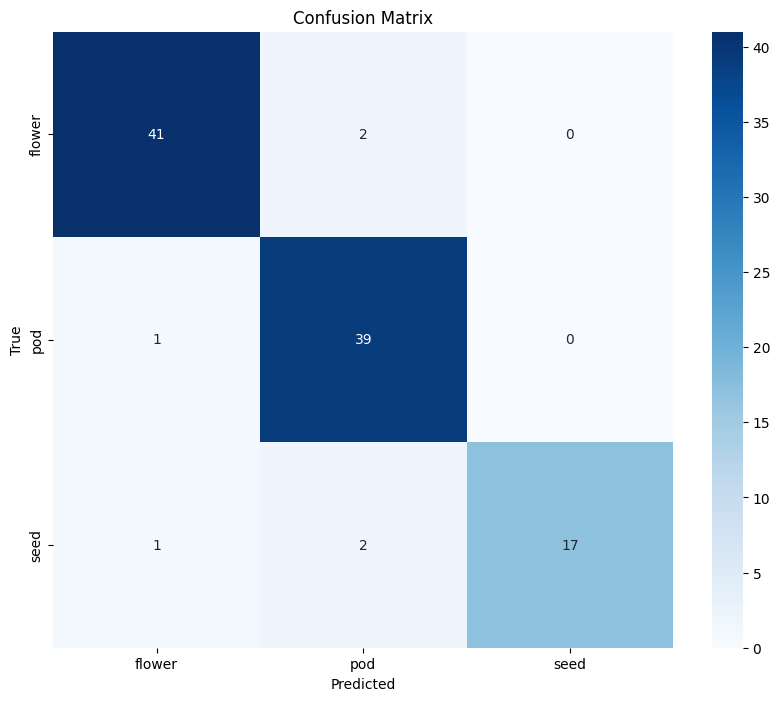

In [3]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models import swin_v2_s, Swin_V2_S_Weights


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_data_dir = 'downloads'
batch_size = 32
num_classes = 3


test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model_path = 'swin_v2_model_fold_1.pth'  # 请根据实际情况更改模型文件名
model = swin_v2_s(weights=Swin_V2_S_Weights.IMAGENET1K_V1)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Classify and calculate indicators
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

# draw the Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


